In [16]:
# fit_many_transects - Loop through transects and collect fits

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.linear_model import LinearRegression, RANSACRegressor, TheilSenRegressor
from scipy import stats
import statsmodels.api as sm
import pymc as pm

In [13]:
data_dir = 'C:/crs/proj/2025_shoreline_fits/'
#fn = 'Northshore_LT_intersects.csv'
fn = 'OuterCapeE_intersects_LT.csv'
df = pd.read_csv(data_dir+fn)

# Convert to datetime format
df["date"] = pd.to_datetime(df["ShorelineI"], format="%m/%d/%Y")

# Function to convert datetime to decimal year
def datetime_to_decimal_year(dt):
    year = dt.year
    start_of_year = pd.Timestamp(f"{year}-01-01")
    end_of_year = pd.Timestamp(f"{year+1}-01-01")
    decimal_year = year + (dt - start_of_year).total_seconds() / (end_of_year - start_of_year).total_seconds()
    return decimal_year

# Apply function to convert each date
df["decimal_year"] = df["date"].apply(datetime_to_decimal_year)
df

,<Feature Name>,<Feature Type>,TransectID,TransOrder,BaselineID,ShorelineI,Distance,IntersectX,IntersectY,Uncertaint,...,BIAS,BIAS_X,BIAS_Y,Bias_Uncer,<Feature Description>,<Feature Layer Name>,<Index in Layer>,<Last Modified Time>,date,decimal_year
0,<UNNAMED FEATURE>,Unknown Point Feature,1,1,1,07/01/1933,1.586844,403402.44,4654101.5,10.8,...,7.120267,403408.63,4654098.0,11.433539,Unknown Point Feature,OuterCapeE_intersects_LT.shp,0,NaN,1933-07-01,1933.495890
1,<UNNAMED FEATURE>,Unknown Point Feature,1,1,1,07/01/1951,-23.892435,403380.28,4654114.1,10.8,...,7.120267,403386.47,4654110.5,11.433539,Unknown Point Feature,OuterCapeE_intersects_LT.shp,1,NaN,1951-07-01,1951.495890
2,<UNNAMED FEATURE>,Unknown Point Feature,1,1,1,04/01/1954,-26.175999,403378.29,4654115.2,10.8,...,7.120267,403384.49,4654111.7,11.433539,Unknown Point Feature,OuterCapeE_intersects_LT.shp,2,NaN,1954-04-01,1954.246575
3,<UNNAMED FEATURE>,Unknown Point Feature,1,1,1,09/01/1970,-83.339168,403328.58,4654143.4,5.1,...,7.120267,403334.77,4654139.9,6.332125,Unknown Point Feature,OuterCapeE_intersects_LT.shp,3,NaN,1970-09-01,1970.665753
4,<UNNAMED FEATURE>,Unknown Point Feature,1,1,1,10/01/1994,-49.111122,403358.35,4654126.5,5.1,...,7.120267,403364.54,4654123.0,6.332125,Unknown Point Feature,OuterCapeE_intersects_LT.shp,4,NaN,1994-10-01,1994.747945
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17100,<UNNAMED FEATURE>,Unknown Point Feature,1730,1730,2,10/01/1994,119.161910,415680.25,4599499.6,5.1,...,8.958841,415680.65,4599490.6,6.364299,Unknown Point Feature,OuterCapeE_intersects_LT.shp,17100,NaN,1994-10-01,1994.747945
17101,<UNNAMED FEATURE>,Unknown Point Feature,1731,1731,2,07/01/1868,-304.196860,415627.61,4599924.9,10.8,...,8.958841,415627.53,4599916.0,11.451389,Unknown Point Feature,OuterCapeE_intersects_LT.shp,17101,NaN,1868-07-01,1868.497268
17102,<UNNAMED FEATURE>,Unknown Point Feature,1731,1731,2,07/01/1951,40.493764,415624.69,4599580.2,10.8,...,8.958841,415624.61,4599571.3,11.451389,Unknown Point Feature,OuterCapeE_intersects_LT.shp,17102,NaN,1951-07-01,1951.495890
17103,<UNNAMED FEATURE>,Unknown Point Feature,1731,1731,2,07/01/1978,84.914223,415624.31,4599535.8,5.1,...,8.958841,415624.24,4599526.9,6.364299,Unknown Point Feature,OuterCapeE_intersects_LT.shp,17103,NaN,1978-07-01,1978.495890


In [14]:
def r2_from_predictions( x, y, slope, intercept ):
    # For fits that don't return r2, calculate from the data and the fit
    # Compute predicted values
    y_pred = slope * x + intercept
    
    # Compute r2
    SS_total = np.sum((y - np.mean(y)) ** 2)  # Total Sum of Squares
    SS_residual = np.sum((y - y_pred) ** 2)   # Residual Sum of Squares
    r_squared = 1 - (SS_residual / SS_total)
    return r_squared

In [17]:
transects = np.unique(df['TransectID'])
n_list=[]
t_list=[]
yr_start_list=[]
yr_end_list=[]
lat_list=[]
lon_list=[]
OLSslope_list=[]
OLSslope_CIlow_list=[]
OLSslope_CIhi_list=[]
OLSr2_list=[]
WLSslope_list=[]
WLSslope_CIlow_list=[]
WLSslope_CIhi_list=[]
WLSr2_list=[]
TSslope_list=[]
TSslope_CIlow_list=[]
TSslope_CIhi_list=[]
TSr2_list=[]
RANslope_list = []
RANr2_list = []

# Pre-filter the dataframe to keep only rows where decimal_year >= 1970
dff = df[df["decimal_year"] >= 1970]

for tid in dff["TransectID"].unique():  # Iterate only over existing TransectIDs
    tdf = dff[dff["TransectID"] == tid].sort_values(by="decimal_year")

    if len(tdf) >= 3:  # Ensure at least 3 valid rows
        x = tdf['decimal_year'].values - 1970
        y = tdf['Bias_Dista'].values
        yu = tdf['Bias_Uncer'].values
        
        t_list.append(tid)
        n_list.append(len(x))
        yr_start_list.append(tdf['decimal_year'].values[0])  # First valid year
        yr_end_list.append(tdf['decimal_year'].values[-1])  # Last year
        lon_list.append(tdf['IntersectX'].values[-1])  # Last latitude
        lat_list.append(tdf['IntersectY'].values[-1])  # Last longitude

        # Set up for statsmodels OLS and WLS
        # need a column of ones to fit intercept
        X = np.column_stack( (x, np.ones_like(x) ))
        weights = 1./( yu**2 )

        # Ordinary least-squares fit
        OLSfit = sm.OLS(y, X).fit()
        OLS_slope, OLS_intercept = OLSfit.params
        OLS_pvalues = OLSfit.pvalues        
        # Compute the 95% confidence interval for all parameters
        OLSconf_int = OLSfit.conf_int(alpha=0.05)  # Default is 95% CI       
        # Extract the slope's confidence interval
        OLSslope_CI = OLSconf_int[0]  # First row corresponds to the slope
        OLSslope_list.append( OLS_slope )
        OLSslope_CIlow_list.append( OLSslope_CI[0] )
        OLSslope_CIhi_list.append( OLSslope_CI[1] )
        OLSr2_list.append( OLSfit.rsquared )

        # Weighted least-squares fit
        WLSfit = sm.WLS(y, X, weights=weights).fit()
        WLS_slope, WLS_intercept = WLSfit.params
        WLS_pvalues = WLSfit.pvalues        
        # Compute the 95% confidence interval for all parameters
        WLSconf_int = WLSfit.conf_int(alpha=0.05)  # Default is 95% CI       
        # Extract the slope's confidence interval
        WLSslope_CI = WLSconf_int[0]  # First row corresponds to the slope
        WLSslope_list.append( WLS_slope )
        WLSslope_CIlow_list.append( WLSslope_CI[0] )
        WLSslope_CIhi_list.append( WLSslope_CI[1] )
        WLSr2_list.append( WLSfit.rsquared )

        #Theil-Sen fit
        # https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mstats.theilslopes.html
        res_theil = stats.theilslopes(y, x, alpha=0.95, method='separate' )
        TSslope_list.append( res_theil.slope )
        TSslope_CIlow_list.append( res_theil.low_slope ) 
        TSslope_CIhi_list.append( res_theil.high_slope )
        TSr2_list.append( r2_from_predictions( x, y, res_theil.slope, res_theil.intercept ) )
        
dft = pd.DataFrame({
    "transect": t_list,
    "N": n_list,
    "Year Start": yr_start_list,
    "Year End": yr_end_list,
    "Latitude": lat_list,
    "Longitude": lon_list,
    "OLS slope": OLSslope_list,
    "OLS slope CIlow": OLSslope_CIlow_list,
    "OLS slope CIhi": OLSslope_CIhi_list,
    "OLS r2": OLSr2_list,
    "WLS slope": WLSslope_list,
    "WLS slope CIlow": WLSslope_CIlow_list,
    "WLS slope CIlhi": WLSslope_CIhi_list,
    "WLS r2": WLSr2_list,
    "TS slope": TSslope_list,
    "TS slope CIlow": TSslope_CIlow_list,
    "TS slope CIlhi": TSslope_CIhi_list,
    "TS r2": TSr2_list
})

In [18]:
dft['slope std_dev'] = dft[['OLS slope', 'WLS slope', 'TS slope']].std(axis=1)


# Save to CSV
csv_filename = fn.replace(".csv", "_slope_fits.csv")
dft.to_csv(data_dir+csv_filename, index=False)

# Print confirmation
print(f"DataFrame saved to {data_dir+csv_filename}")

DataFrame saved to C:/crs/proj/2025_shoreline_fits/OuterCapeE_intersects_LT_slope_fits.csv


In [19]:
dft = pd.read_csv( data_dir+csv_filename )
dft.describe()

,transect,N,Year Start,Year End,Latitude,Longitude,OLS slope,OLS slope CIlow,OLS slope CIhi,OLS r2,WLS slope,WLS slope CIlow,WLS slope CIlhi,WLS r2,TS slope,TS slope CIlow,TS slope CIlhi,TS r2,slope std_dev
count,1718.000000,1718.000000,1718.000000,1718.000000,1.718000e+03,1718.000000,1718.000000,1718.000000,1718.000000,1718.000000,1718.000000,1718.000000,1718.000000,1.718000e+03,1718.000000,1718.000000,1718.000000,1718.000000,1718.000000
mean,860.502328,6.796275,1972.455178,2018.173384,4.636619e+06,414373.838743,-1.623679,-6.588760,3.341403,0.570997,-2.337483,-8.939934,4.264967,4.721052e-01,-1.742448,-7.778705,4.445866,0.370591,1.280973
std,497.458202,0.878361,4.738437,1.430665,1.935845e+04,8371.153832,7.375427,16.453277,15.940382,0.286536,8.410123,20.275803,19.033579,2.918762e-01,7.428440,14.742129,15.579101,0.491272,2.584576
min,1.000000,3.000000,1970.495890,2007.000000,4.599159e+06,396917.730000,-46.521399,-204.060085,-22.447593,0.000020,-55.325742,-320.802654,-22.267501,4.871692e-07,-43.391352,-135.706839,-28.993850,-2.414052,0.009808
25%,430.250000,7.000000,1970.495890,2018.465753,4.619472e+06,407781.515000,-2.118929,-4.638311,-0.537104,0.364035,-2.617136,-6.296835,-0.333417,1.947132e-01,-2.204488,-6.500454,-0.169376,0.108162,0.207465
50%,859.500000,7.000000,1970.665753,2018.471233,4.640631e+06,417674.275000,-1.041153,-2.071190,0.043128,0.628552,-1.238978,-3.190623,0.527754,5.160145e-01,-1.009119,-2.889653,0.688562,0.491284,0.411726
75%,1289.750000,7.000000,1970.665753,2018.471233,4.654736e+06,421305.540000,-0.376362,-1.303321,1.309743,0.813930,-0.298060,-1.947288,2.208814,7.134046e-01,-0.231315,-1.713398,2.464736,0.738863,0.880758
max,1723.000000,8.000000,2000.732240,2018.471233,4.659626e+06,422774.050000,51.389652,15.513522,163.750833,0.999240,45.040423,12.259902,346.692837,9.939547e-01,49.160344,17.547433,295.037718,0.997205,23.513974


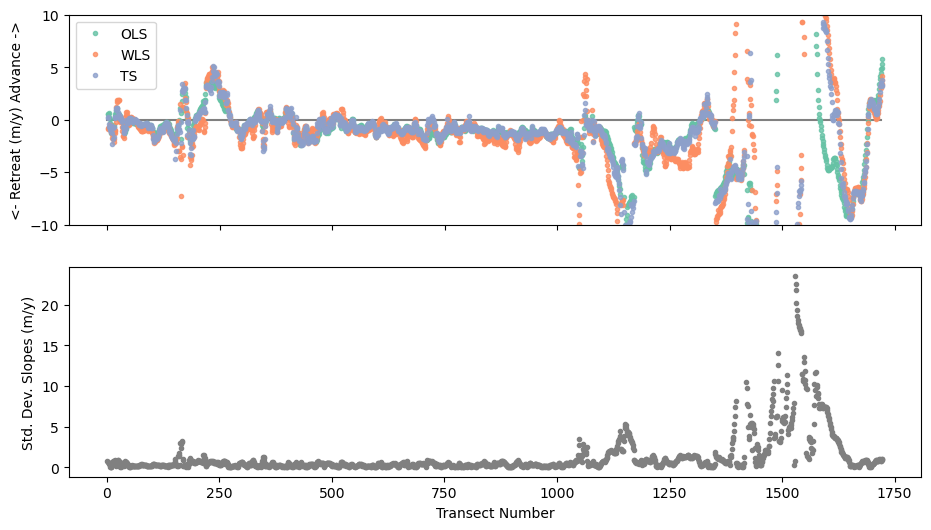

In [22]:
colors =['#66c2a5','#fc8d62','#8da0cb']
fig, (ax0, ax1) = plt.subplots(2, 1, figsize = (11,6) )
ax0.plot([0, 1720],[0,0],'-',c='gray')
ax0.plot(dft['transect'],dft['OLS slope'],'.', c=colors[0], alpha=.8, label='OLS')
ax0.plot(dft['transect'],dft['WLS slope'],'.', c=colors[1], alpha=.8, label='WLS')
ax0.plot(dft['transect'],dft['TS slope'],'.', c=colors[2], alpha=.8, label='TS')
ax0.set_ylabel('<- Retreat (m/y) Advance ->')
ax0.set_ylim(-10, 10)
ax0.set_xticklabels([])
ax0.legend()
ax1.plot(dft['transect'],dft['slope std_dev'],'.',c='gray')
ax1.set_xlabel('Transect Number')
ax1.set_ylabel('Std. Dev. Slopes (m/y)')
fig_name = fn.replace(".csv", "slopes_std.png")
plt.savefig(data_dir+fig_name, dpi=200, bbox_inches='tight')

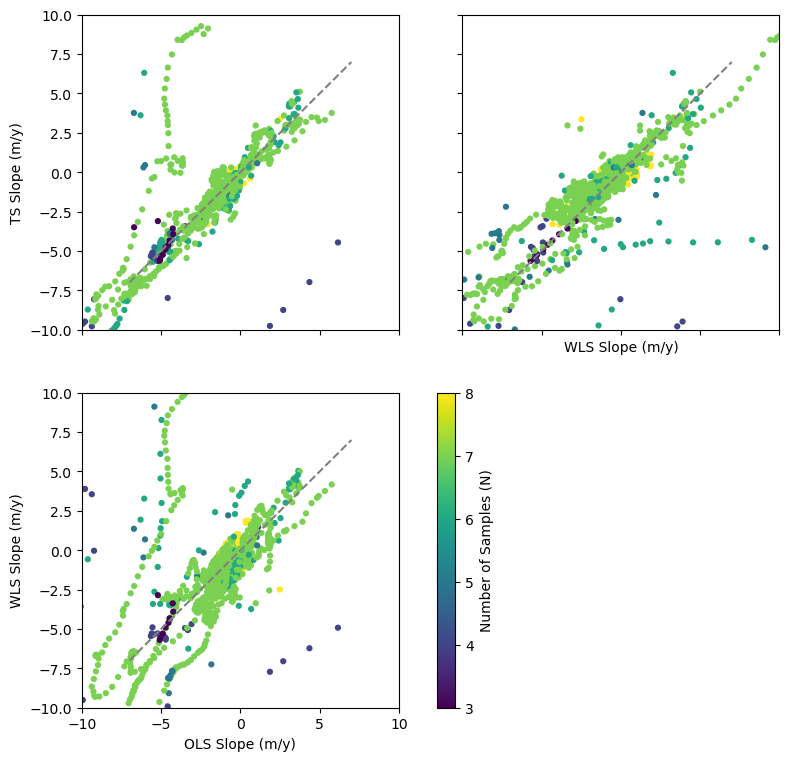

In [23]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(9, 9), sharex=True, sharey=True)

# First subplot
axs[0, 0].plot([-7, 7], [-7, 7], '--', c='gray')
sc1 = axs[0, 0].scatter(dft['OLS slope'], dft['TS slope'], s=12, c=dft['N'])
axs[0, 0].set_ylim(-10, 10)
axs[0, 0].set_xlim(-10, 10)
axs[0, 0].set_ylabel('TS Slope (m/y)')

# Second subplot
axs[1, 0].plot([-7, 7], [-7, 7], '--', c='gray')
sc2 = axs[1, 0].scatter(dft['OLS slope'], dft['WLS slope'], s=12, c=dft['N'])
axs[1, 0].set_ylim(-10, 10)
axs[1, 0].set_xlim(-10, 10)
axs[1, 0].set_ylabel('WLS Slope (m/y)')
axs[1, 0].set_xlabel('OLS Slope (m/y)')

# Third subplot (store handle for colorbar)
axs[0, 1].plot([-7, 7], [-7, 7], '--', c='gray')
im = axs[0, 1].scatter(dft['WLS slope'], dft['TS slope'], s=12, c=dft['N'])
axs[0, 1].set_ylim(-10, 10)
axs[0, 1].set_xlim(-10, 10)
axs[0, 1].set_xlabel('WLS Slope (m/y)')

# Turn off last subplot
axs[1, 1].set_axis_off()
# **Create a colorbar with controlled size**
cbar_ax = fig.add_axes([0.52, 0.11, 0.02, 0.35])  # [left, bottom, width, height]
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label('Number of Samples (N)')


fig_name = fn.replace(".csv", "slope_scatter.png")
plt.savefig(data_dir+'/plots/'+fig_name, dpi=200, bbox_inches='tight')

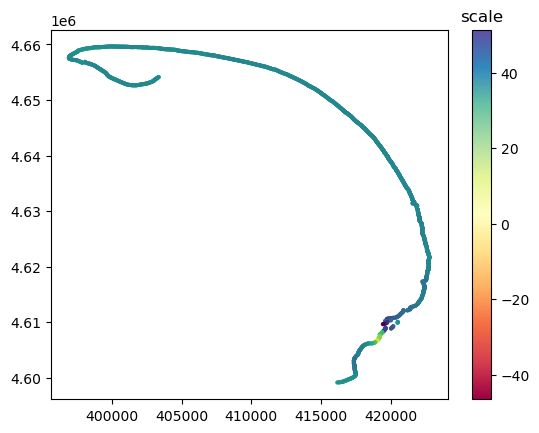

In [29]:
from matplotlib.cm import ScalarMappable
fig, ax = plt.subplots(1, 1)
cmap = plt.get_cmap("Spectral")
slopes = dft['OLS slope']
norm = plt.Normalize(slopes.min(), slopes.max())
#norm = plt.Normalize(-1, 1 )
plt.scatter( dft['Longitude'], dft['Latitude'],s=4, c=dft['OLS slope'] )
sm =  ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.ax.set_title("scale")
fig_name = fn.replace(".csv", "slope_map.png")
plt.savefig(data_dir+'/plots/'+fig_name, dpi=200, bbox_inches='tight')

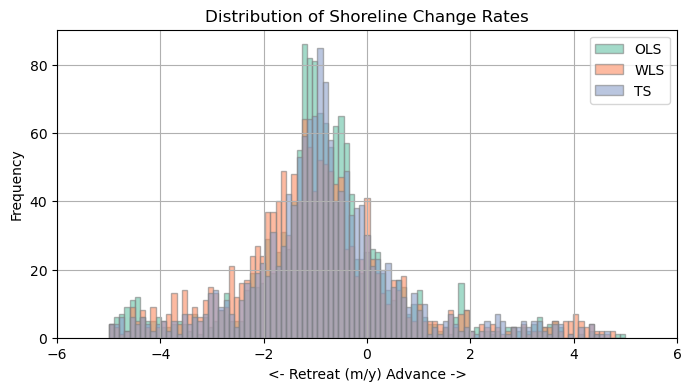

In [26]:
# Get group names and define colors

colors =['#66c2a5','#fc8d62','#8da0cb']
bins = np.linspace( -5, 5, 100 )

ax = dft['OLS slope'].hist(figsize=(8, 4), edgecolor='gray', bins=bins, color=colors[0], alpha = .6, label = 'OLS' )
ax = dft['WLS slope'].hist(figsize=(8, 4), edgecolor='gray', bins=bins, color=colors[1], alpha = .6, label = 'WLS' )
ax = dft['TS slope'].hist(figsize=(8, 4), edgecolor='gray', bins=bins, color=colors[2], alpha = .6, label = 'TS')
plt.xlim(-6, 6)
plt.legend()

# Add a legend
#ax.legend(group_name)

# Add a title and axis label
ax.set_title('Distribution of Shoreline Change Rates')
ax.set_xlabel('<- Retreat (m/y) Advance ->')
ax.set_ylabel('Frequency')
fig_name = fn.replace(".csv", "slopes_hist.png")
plt.savefig(data_dir+'/plots/'+fig_name, dpi=200, bbox_inches='tight')

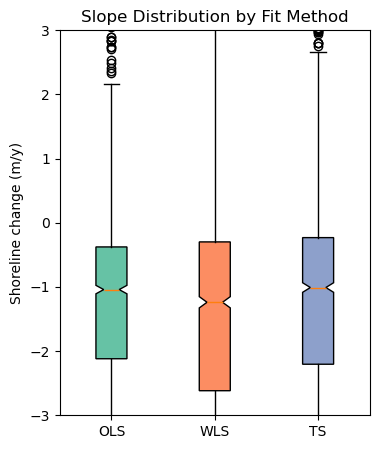

In [27]:
# boxplots of slope distributions
slopes = [ dft['OLS slope'], dft['WLS slope'], dft['TS slope'] ]
labels = ['OLS', 'WLS', 'TS']
fig, ax = plt.subplots(figsize = (4, 5) )
ax.set_ylabel('Shoreline change (m/y)')

bplot = ax.boxplot(slopes, notch=True,
                   patch_artist=True,  # fill with color
                   tick_labels=labels)  # will be used to label x-ticks

# fill with colors
for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)
plt.ylim( -3, 3 )
plt.title('Slope Distribution by Fit Method')
fig_name = fn.replace(".csv", "slopes_box.png")
plt.savefig(data_dir+'/plots/'+fig_name, dpi=200, bbox_inches='tight')